In [1]:
import matplotlib.pyplot as plt
import pickle


In [2]:
def get_threshold(files_list, model):
    # select all experiments for all supports and return the best threshold according to the roc curve
    # NOTE: this does provide a bit of an advantage in terms of performance
    # (instead of using a separate validation set to define the threshold)
    # but detectors still fail to detect drifts for small subgroups

    y_true = []
    y_pred = []
    
    for fname in files_list:
        with open(fname, "rb") as f:
            results = pickle.load(f)
        
        if model not in results:
            continue
    
        y_pred.extend(results[model]["y_pred"])
        y_true.extend(results[model]["y_true"])
    
    fpr, tpr, thresh = roc_curve(y_true, y_pred)
    best_thresh = thresh[np.argmax(tpr - fpr)]
    return best_thresh

In [3]:
from glob import glob
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve
import numpy as np

import re

def fpr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fp / (fp + tn)
    
def fnr(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn / (fn + tp)

supports = []
f1s = {}
accuracies = {}
fprs = {}
fnrs = {}

all_files = glob("results-best1.0/*_nruns_100.pkl")

# load model names, for the preparation of the thresholds
with open(all_files[0], "rb") as f:
    results = pickle.load(f)

thresholds = {
    k: get_threshold(all_files, k) for k in results
}

for fname in all_files:
    sg = float(re.search("sg_(.*)_pert", fname).group(1))
    
    with open(fname, "rb") as f:
        results = pickle.load(f)
    
    supports.append(sg)

    for key in results:
        y_true, y_pred = results[key]["y_true"], results[key]["y_pred"]
        best_thresh = thresholds[key]

        y_pred = (y_pred >= best_thresh).astype(int)
        model_name, config = key

        if model_name not in f1s:
            f1s[model_name] = []
            accuracies[model_name] = []
            fprs[model_name] = []
            fnrs[model_name] = []

        f1s[model_name].append(f1_score(y_true, y_pred))
        accuracies[model_name].append(accuracy_score(y_true, y_pred))
        fprs[model_name].append(fpr(y_true, y_pred))
        fnrs[model_name].append(fnr(y_true, y_pred))


supports = np.array(supports)
f1s = { k: np.array(v)[np.argsort(supports)] for k, v in f1s.items() }
accuracies = { k: np.array(v)[np.argsort(supports)] for k, v in accuracies.items() }
fprs = { k: np.array(v)[np.argsort(supports)] for k, v in fprs.items() }
fnrs = { k: np.array(v)[np.argsort(supports)] for k, v in fnrs.items() }

supports = np.sort(supports)

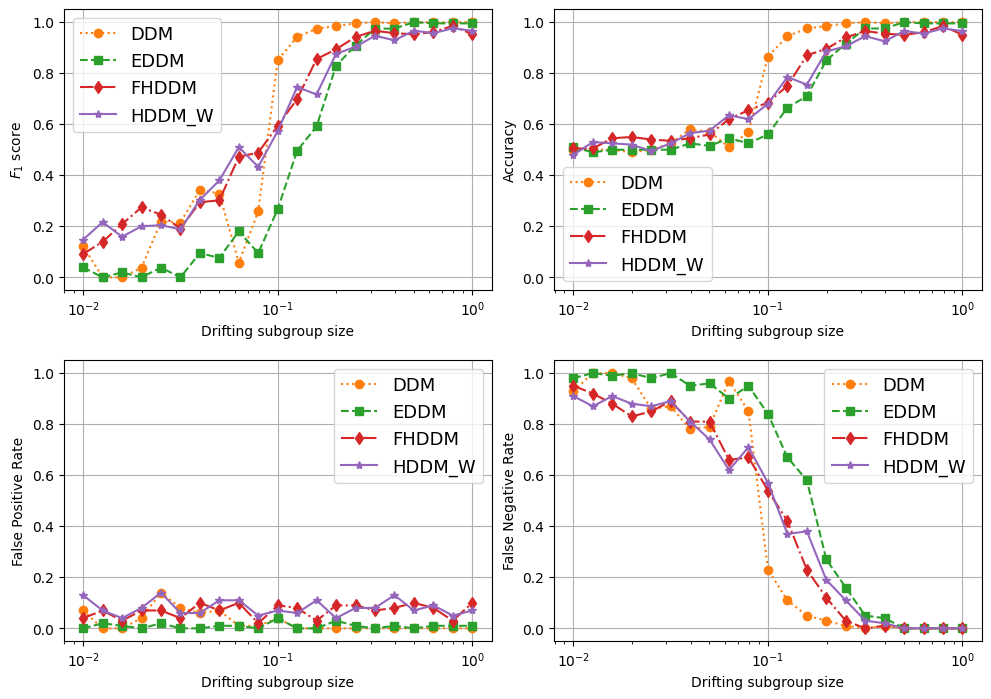

In [4]:
fig , ax = plt.subplots(2, 2, figsize=(10,7))
# increase font size
plt.rcParams.update({'font.size': 13})
plt.tight_layout()

markers = "osd^*"
colors = [ 'tab:orange', 'tab:green', 'tab:red','tab:olive', 'tab:purple', 'tab:cyan' ]
ls = [":", "--", "-.", None, "-"]
fig.subplots_adjust(hspace=0.25)

for i, (metrics, metric_name) in enumerate(zip([f1s, accuracies, fprs, fnrs], ["$F_1$ score", "Accuracy", "False Positive Rate", "False Negative Rate"])):
    a,b = i//2, i%2
    for j, (model, perf) in enumerate(metrics.items()):
        if model == "HDDM_A":
            continue
        ax[a,b].plot(supports, perf, label=model, marker=markers[j], color=colors[j], ls=ls[j])

    ax[a,b].legend()
    ax[a,b].set_xscale("log")
    ax[a,b].grid()
    ax[a,b].set_xlabel("support")
    ax[a,b].set_ylabel(metric_name)
    ax[a,b].set_xlabel("Drifting subgroup size")
    ax[a,b].set_ylim(-0.05, 1.05)

fig.savefig("performance2x2.pdf", bbox_inches="tight")